# Window Function

In [32]:
from scipy import signal
from scipy.fft import fft, fftshift
import numpy as np

import matplotlib.pyplot as plt

from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker

# Atlas

In [33]:
atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')

# The first label correspond to the background
print('The atlas contains {} non-overlapping regions'.format(len(atlas.labels) - 1))

The atlas contains 48 non-overlapping regions


In [34]:
# Instantiate the masker with label image and label values
masker = NiftiLabelsMasker(atlas.maps,
                           labels=atlas.labels,
                           standardize=True)

# Visualize the atlas
# Note that we need to call fit prior to generating the mask
masker.fit()

# At this point, no functional image has been provided to the masker.
report = masker.generate_report()
report

/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/maskers/nifti_labels_masker.py:305: UserWarning: No image provided to fit in NiftiLabelsMasker. Plotting ROIs of label image on the MNI152Template for reporting.
  warnings.warn(msg)


label value,region name,size (in mm^3),relative size (in %)
1,Frontal Pole,123176,11.75
2,Insular Cortex,18728,1.79
3,Superior Frontal Gyrus,40640,3.88
4,Middle Frontal Gyrus,42528,4.06
5,"Inferior Frontal Gyrus, pars triangularis",8824,0.84
6,"Inferior Frontal Gyrus, pars opercularis",11072,1.06
7,Precentral Gyrus,68584,6.54
8,Temporal Pole,37688,3.59
9,"Superior Temporal Gyrus, anterior division",4168,0.4
10,"Superior Temporal Gyrus, posterior division",14640,1.4


In [35]:
subjects_ts = ['/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_1074_v164_.nii', '/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_6264_v164_.nii']

# Fitting the mask and generating a report
masker.fit(subjects_ts[1])

# We can again generate a report, but this time, the provided functional
# image is displayed with the ROI of the atlas.
# The report also contains a summary table giving the region sizes in mm3
report = masker.generate_report()
report

label value,region name,size (in mm^3),relative size (in %)
1,Frontal Pole,123176,11.75
2,Insular Cortex,18728,1.79
3,Superior Frontal Gyrus,40640,3.88
4,Middle Frontal Gyrus,42528,4.06
5,"Inferior Frontal Gyrus, pars triangularis",8824,0.84
6,"Inferior Frontal Gyrus, pars opercularis",11072,1.06
7,Precentral Gyrus,68584,6.54
8,Temporal Pole,37688,3.59
9,"Superior Temporal Gyrus, anterior division",4168,0.4
10,"Superior Temporal Gyrus, posterior division",14640,1.4


In [36]:
# Process the data with the NiftiLablesMasker
# In order to extract the signals, we need to call transform on the functional data
signals = masker.transform(subjects_ts[1])
# signals is a 2D matrix, (n_time_points x n_regions)
signals.shape

(164, 48)

In [37]:
def window_generate(M:int=1):
    """
    Generate different window type
    :param M: amount of time points
    :return: list with the windows
    """
    # Windows type
    hann_window = signal.windows.hann(M)
    hamming_window = signal.windows.hamming(M)
    tukey_window = signal.windows.tukey(M)
    #rectangular_window = signal.windows.tukey(M, alpha=0)
    rectangular_window = signal.windows.boxcar(M)

    return [rectangular_window, hann_window, hamming_window, tukey_window], ['rect', 'hann', 'hamming', 'tukey']

wt, wt_dict = window_generate(signals.shape[0])

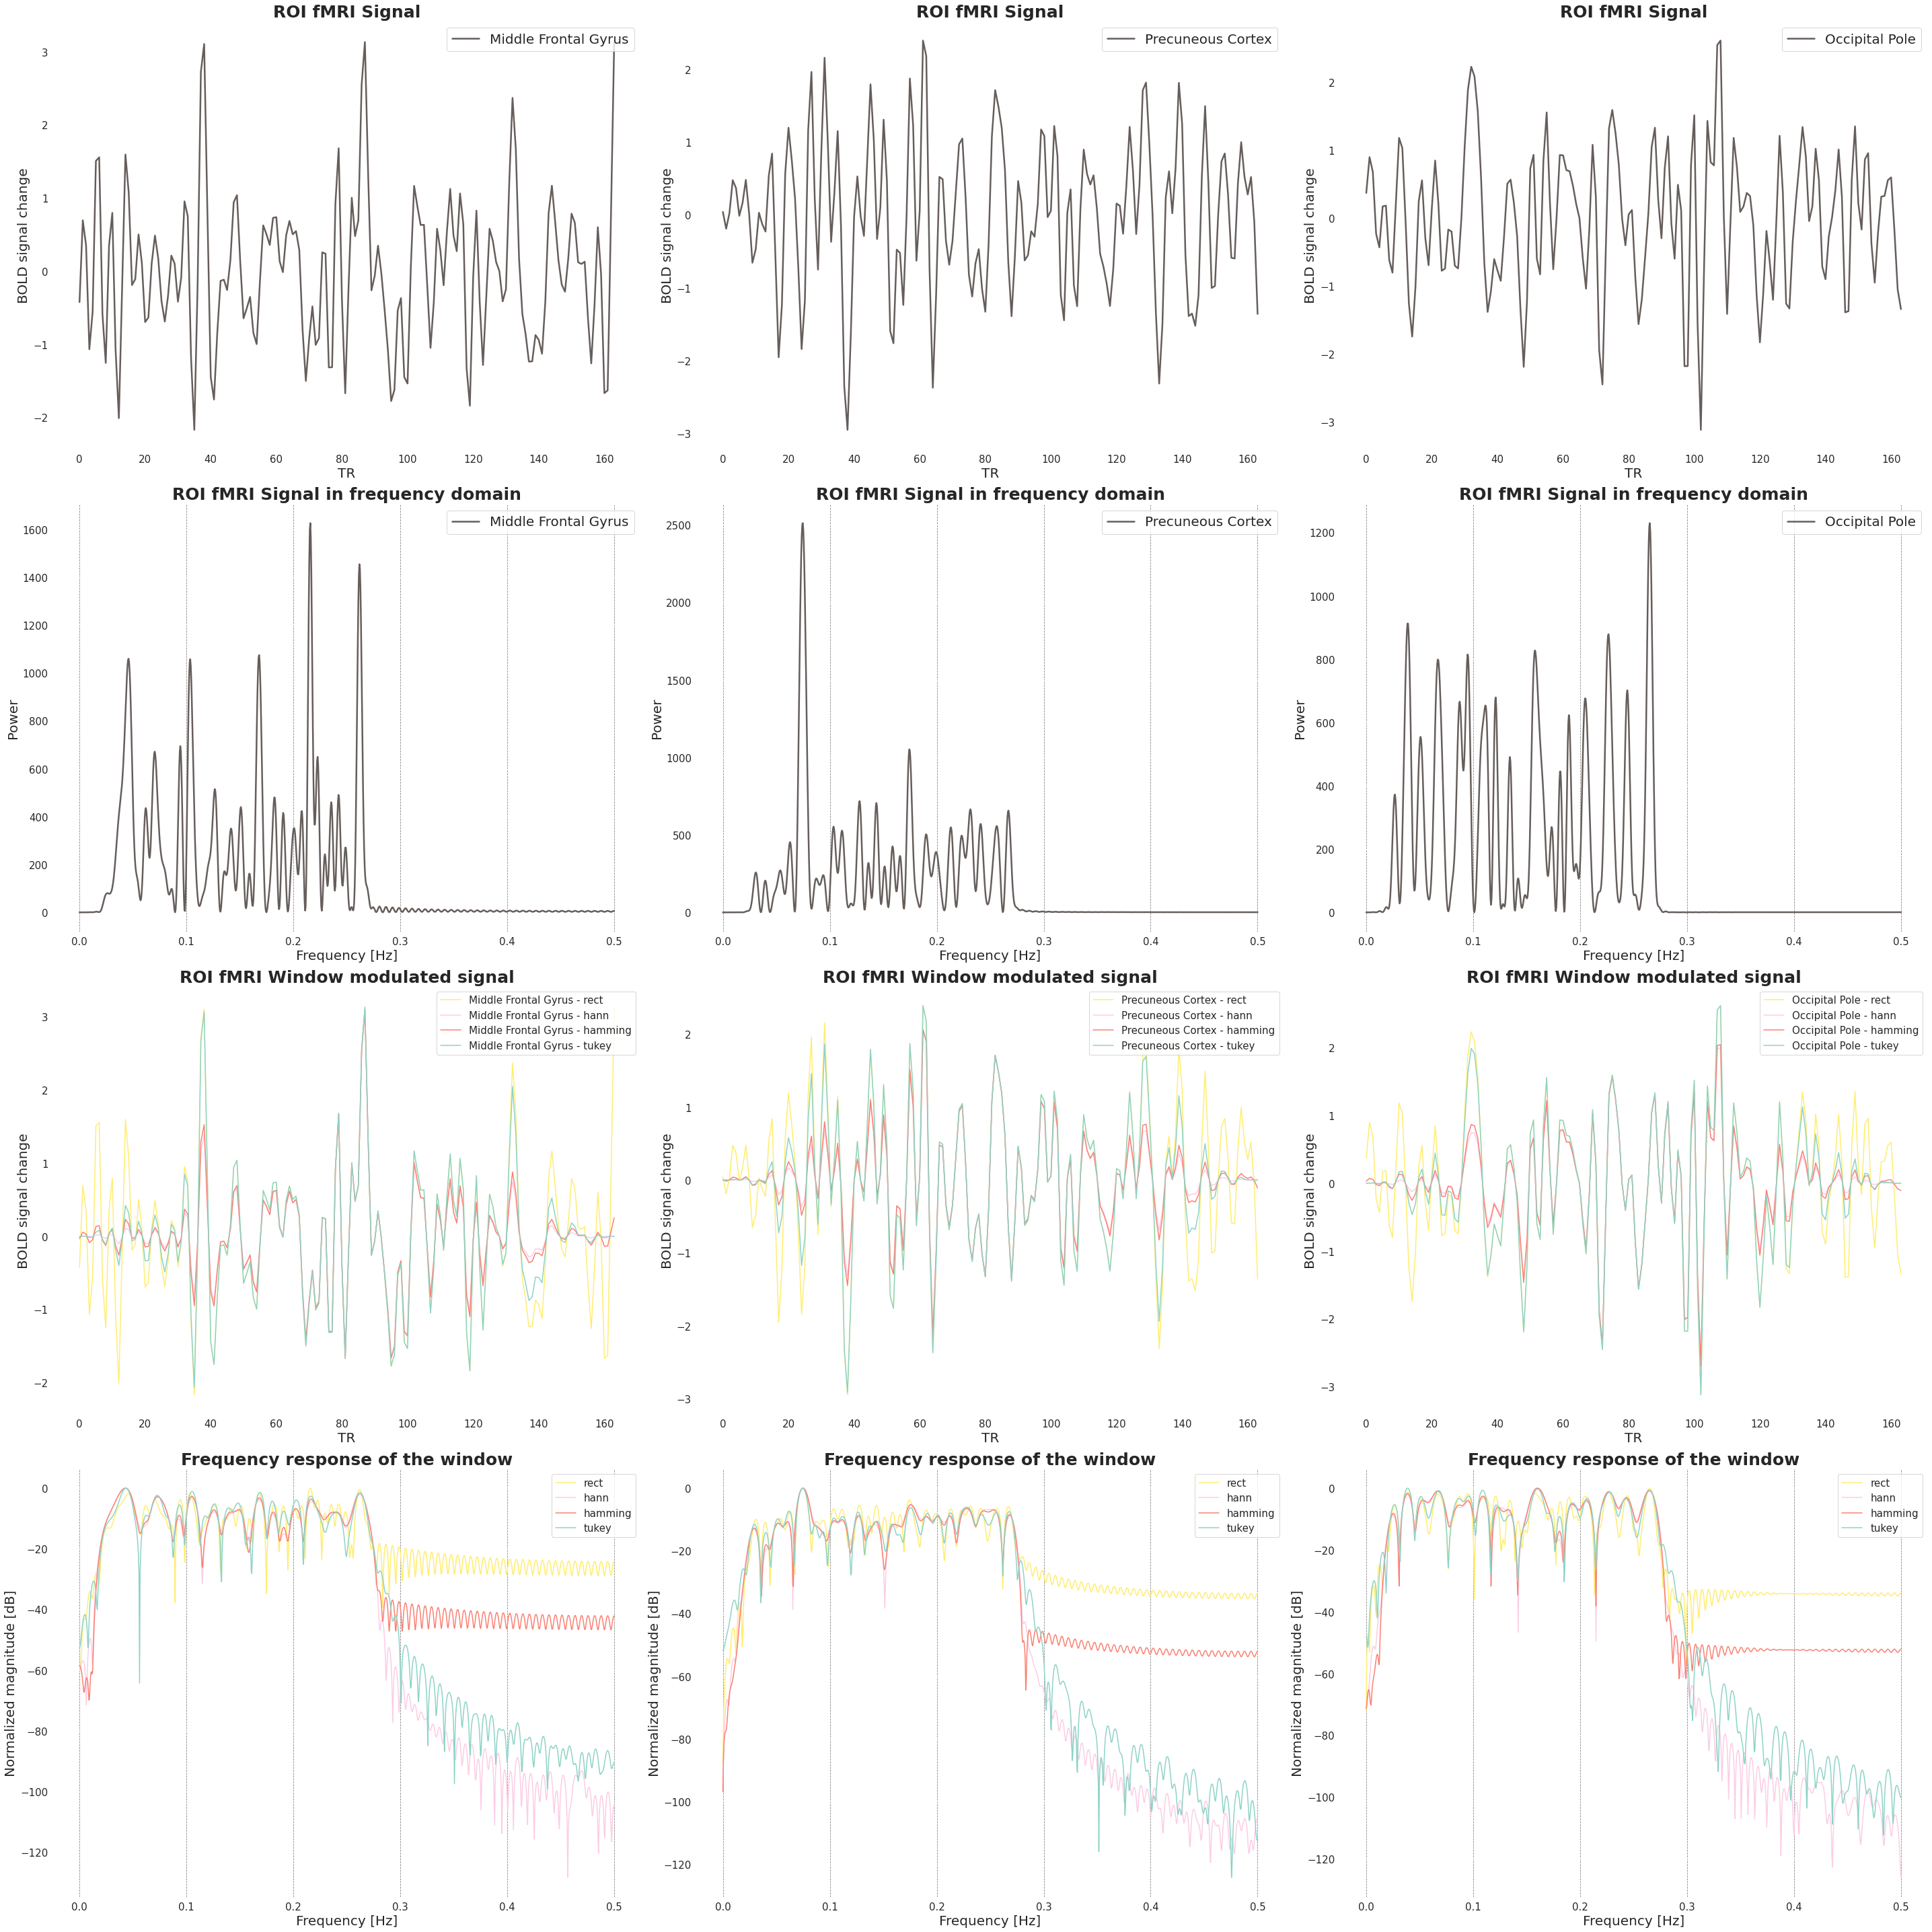

In [38]:
rois = [3, 30, 47]

t = np.arange(0, signals.shape[0], step=1)
colormap = plt.cm.Set3_r #nipy_spectral, Set1,Paired
colors = [colormap(i) for i in np.linspace(0, 1,len(wt_dict))]

fig, axs = plt.subplots(4, 3, figsize=(40, 40), facecolor='white')
for idx, label_idx in enumerate(rois):
    axs[0, idx].plot(signals[:, label_idx], '#665e5b',
            linewidth=2.5,
            label=atlas.labels[label_idx + 1])  # 0 is background
    axs[0, idx].legend(loc='upper right', fontsize=20, facecolor='white', fancybox=True)
    axs[0, idx].set_facecolor('white')
    axs[0, idx].set_title('ROI fMRI Signal', fontsize=25, weight='bold')
    axs[0, idx].set_xlabel('TR', fontsize=20)
    axs[0, idx].set_ylabel('BOLD signal change', fontsize=20)
    for tick in axs[0, idx].xaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    for tick in axs[0, idx].yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    axs[0, idx].set_axis_on()

for idx, label_idx in enumerate(rois):
    n = 2048  #4096
    yf = np.fft.rfft(signals[:, label_idx], n=n)
    xf = np.fft.rfftfreq(n, d=t[1] - t[0])
    axs[1, idx].plot(xf, yf.real**2 + yf.imag**2, '#665e5b', linewidth=2.5, label=atlas.labels[label_idx + 1])
    axs[1, idx].legend(loc='upper right', fontsize=20, facecolor='white', fancybox=True)
    axs[1, idx].set_facecolor('white')
    axs[1, idx].set_title('ROI fMRI Signal in frequency domain', fontsize=25, weight='bold')
    axs[1, idx].set_xlabel('Frequency [Hz]', fontsize=20)
    axs[1, idx].set_ylabel('Power', fontsize=20)
    axs[1, idx].xaxis.grid(color='gray', linestyle='dashed')
    for tick in axs[1, idx].xaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    for tick in axs[1, idx].yaxis.get_major_ticks():
        tick.label.set_fontsize(15)
    axs[1, idx].set_axis_on()

for idx, label_idx in enumerate(rois):
    for widx, w in enumerate(wt):
        axs[2, idx].plot(signals[:, label_idx] * w,
                        linewidth=1.5,
                        label=f'{atlas.labels[label_idx + 1]} - {wt_dict[widx]}', c=colors[widx])  # 0 is background
        axs[2, idx].legend(loc='upper right', fontsize=15, facecolor='white', fancybox=True)
        axs[2, idx].set_facecolor('white')
        axs[2, idx].set_title('ROI fMRI Window modulated signal', fontsize=25, weight='bold')
        axs[2, idx].set_xlabel('TR', fontsize=20)
        axs[2, idx].set_ylabel('BOLD signal change', fontsize=20)
        for tick in axs[2, idx].xaxis.get_major_ticks():
            tick.label.set_fontsize(15)
        for tick in axs[2, idx].yaxis.get_major_ticks():
            tick.label.set_fontsize(15)
        axs[2, idx].set_axis_on()

for idx, label_idx in enumerate(rois):
    for widx, w in enumerate(wt):
        n = 2048
        w = np.fft.rfft(signals[:, label_idx] * w, n=n)
        freqs = np.fft.rfftfreq(n, d=t[1] - t[0])
        response = 20 * np.log10(np.maximum(np.abs(w), 1e-10) / np.abs(w).max())
        axs[3, idx].plot(freqs, response, linewidth=1.5, label=wt_dict[widx], c=colors[widx])
        axs[3, idx].legend(loc='upper right', fontsize=15, facecolor='white', fancybox=True)
        axs[3, idx].set_facecolor('white')
        axs[3, idx].set_title('Frequency response of the window', fontsize=25, weight='bold')
        axs[3, idx].set_xlabel('Frequency [Hz]', fontsize=20)
        axs[3, idx].set_ylabel('Normalized magnitude [dB]', fontsize=20)
        axs[3, idx].xaxis.grid(color='gray', linestyle='dashed')
        for tick in axs[3, idx].xaxis.get_major_ticks():
            tick.label.set_fontsize(15)
        for tick in axs[3, idx].yaxis.get_major_ticks():
            tick.label.set_fontsize(15)
        axs[3, idx].set_axis_on()
        fig.tight_layout()
fig.savefig('response_to_window_function.png')

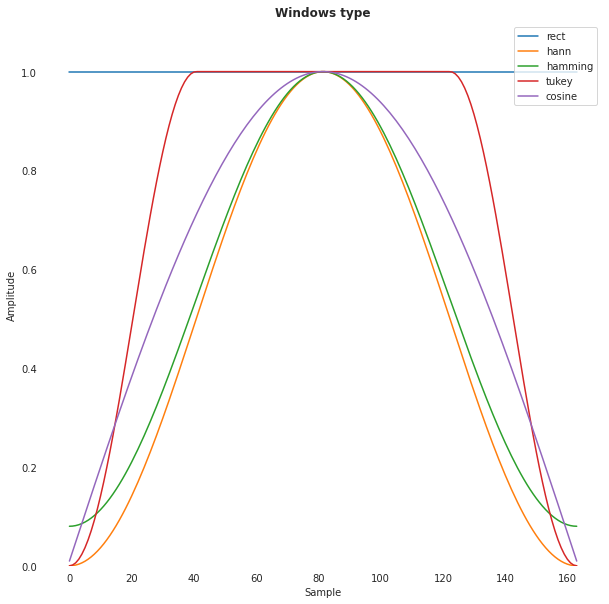

In [56]:
plt.figure(figsize=(10,10), facecolor='white')
ax = plt.axes()
ax.set(facecolor = "white")
plt.plot(wt[0], label='rect')
plt.grid(True, axis='x')
plt.plot(wt[1], label='hann')
plt.grid(True, axis='x')
plt.plot(wt[2], label='hamming')
plt.grid(True, axis='x')
plt.plot(wt[3], label='tukey')
plt.grid(True, axis='x')
plt.plot(signal.windows.cosine(signals.shape[0]), label='cosine')
plt.grid(True, axis='x')

plt.legend(loc='upper right', fontsize=10, facecolor='white', fancybox=True)
plt.title("Windows type", weight='bold')
plt.ylabel("Amplitude")
plt.xlabel("Sample")
plt.ylim([0, 1.1])
plt.grid(True, axis='x')

plt.savefig('windows_type.png')


## Simulated BOLD

In [57]:
n = 200
t = np.arange(n)
# dynamic correlation frequency values (i.e. δf1 = 0.001 Hz and δf2 = 0.006 Hz) in the frequency range of (0,fmin) = (0, 0.01) to be consistent with fMRI correlation connectivities.
f = 0.02
df1 = 0.001
df2 = 0.006
x = np.cos(2*np.pi*(f+df1)*t) + np.cos(2+np.pi*(f+df2)*t)  # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6513676/
wt, wt_dict = window_generate(n)

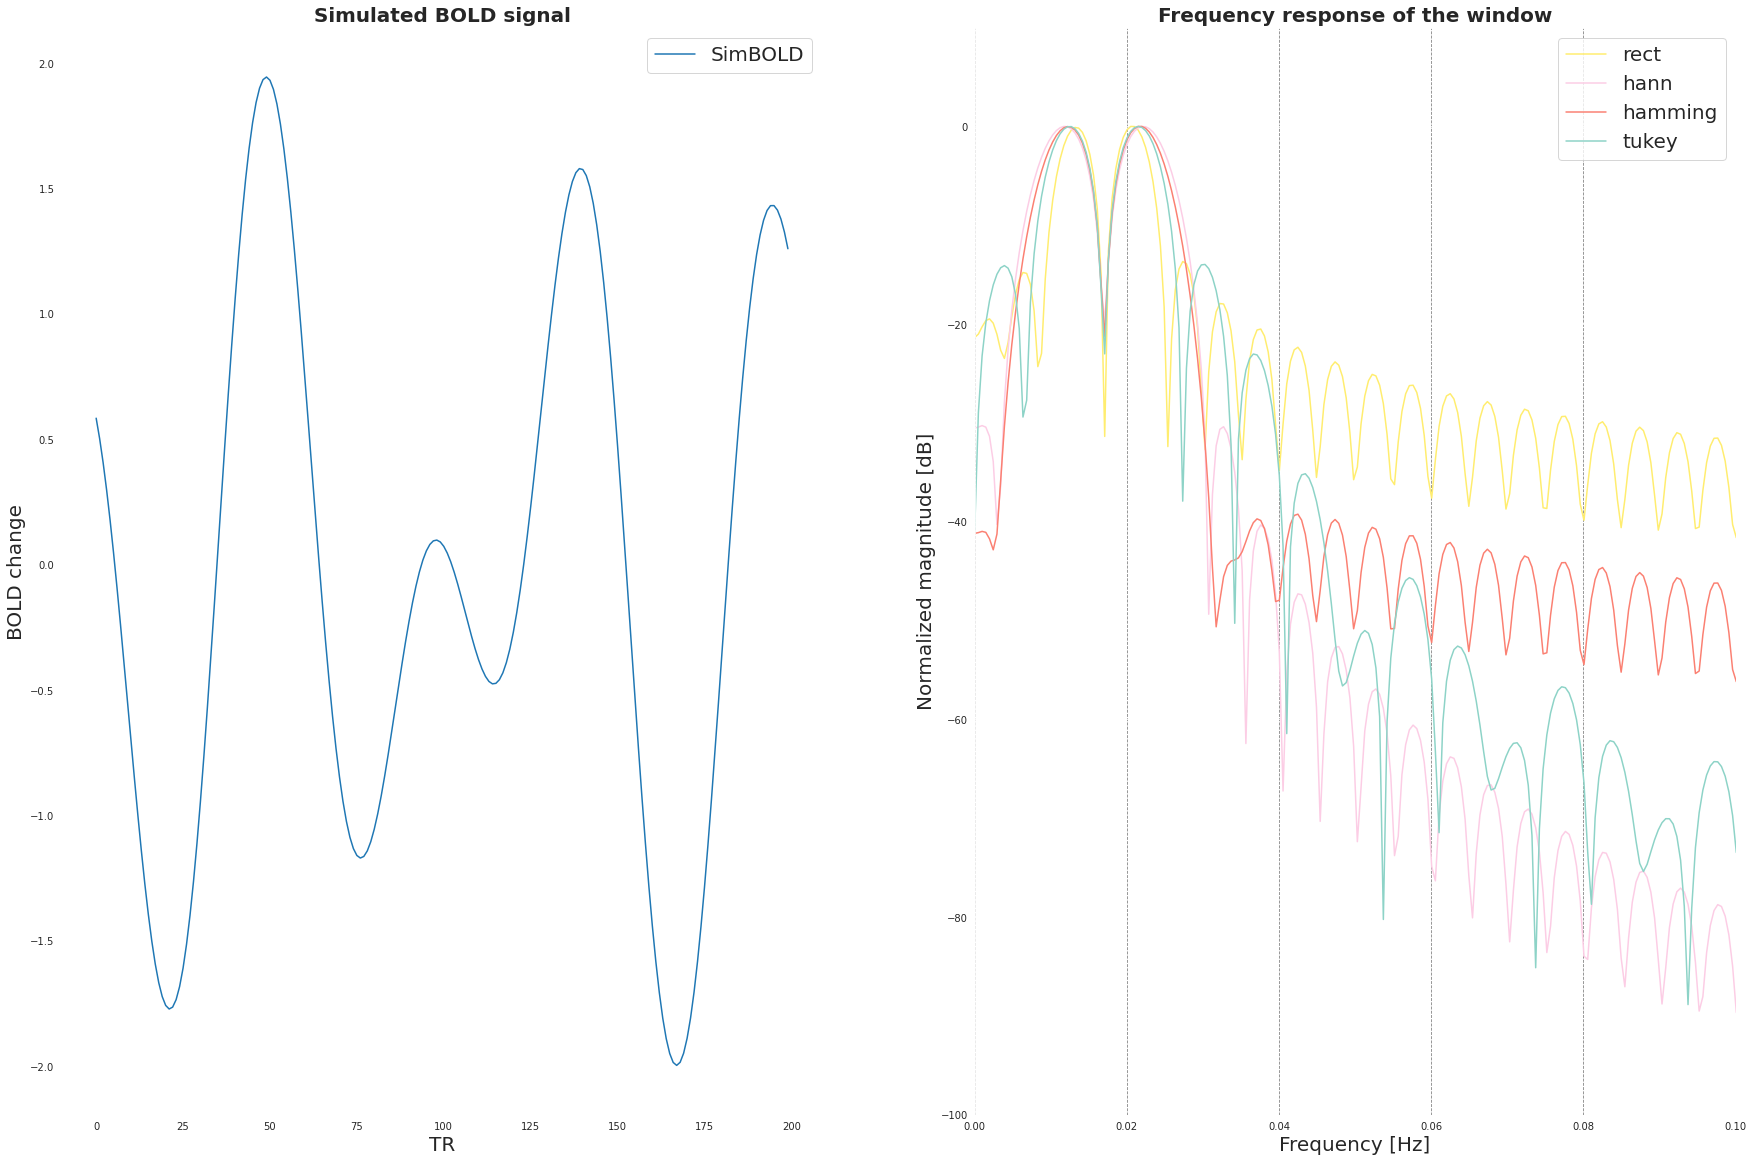

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 20), facecolor='white')
ax1.set(facecolor = "white")
ax2.set(facecolor = "white")
ax1.plot(t, x, label='SimBOLD')
ax1.legend(loc='upper right', facecolor='white', fancybox=True, fontsize=20)
ax1.set_title('Simulated BOLD signal', weight='bold', fontsize=20)
ax1.set_xlabel('TR', fontsize=20)
ax1.set_ylabel('BOLD change', fontsize=20)
ax2.xaxis.grid(color='gray', linestyle='dashed')


for widx, w in enumerate(wt):
    n = 2048
    w = np.fft.rfft(x * w, n=n)
    freqs = np.fft.rfftfreq(n, d=t[1] - t[0])
    response = 20 * np.log10(np.maximum(np.abs(w), 1e-10) / np.abs(w).max())
    ax2.plot(freqs, response, linewidth=1.5, label=wt_dict[widx], c=colors[widx])
    ax2.legend(loc='upper right', facecolor='white', fancybox=True, fontsize=20)
    ax2.set_xlim([0, 0.1])
    ax2.set_ylim([-100, 10])
    ax2.set_title('Frequency response of the window', weight='bold', fontsize=20)
    ax2.set_xlabel('Frequency [Hz]', fontsize=20)
    ax2.set_ylabel('Normalized magnitude [dB]', fontsize=20)
#fig.subplots_adjust(bottom=0.1, right=2, top=1)
fig.savefig('simulated_response_to_window_function.png')


## Correlation matrix

Effect of different window function over dynamic correlation matrix

Its not too useful for comparations.

In [62]:
from utils.sliding_window_fc import dynamic_functional_connectivity
from utils.fmri_signal_extract import signal_extract
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import seaborn as sns
import numpy as np
import pandas as pd

In [63]:
subjects_ts = ['/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/AD_ADNI3_V2/dswau4D_003_S_1074_v164_.nii']

# ts shape (n_subjects), and in each subject shape (vols, rois)
ts, roi_img, labels, masker_type = signal_extract(data=subjects_ts, atlas='/run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/nets_CN_ADNI3.nii')

np_ts = np.asarray(ts)
wl = 20  # window length in vols, in this case for 164 vols with TR=3 the wl = 20 vols = 60 min
ss = 10  # window step size in vols
wt = ['rect', 'hann', 'hamming', 'tukey']

slwin_ts, n_slwin = dynamic_functional_connectivity(np_ts, wl, ss, 'hamming')  # Windowed BOLD time-series

  1 region(s) detected from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/nets_CN_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading regions from /run/media/kevrodz/Salvador/ADNI3_KEV_CLAUDIA/gICA_300ROI_bin/nets_CN_ADNI3.nii
[NiftiMapsMasker.fit_transform] loading mask from Nifti1Image(
shape=(99, 117, 95),
affine=array([[   2.,    0.,    0.,  -98.],
       [   0.,    2.,    0., -134.],
       [   0.,    0.,    2.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
Resampling mask


/home/kevrodz/Documents/Master/neuro/lib/python3.10/site-packages/nilearn/_utils/cache_mixin.py:304: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


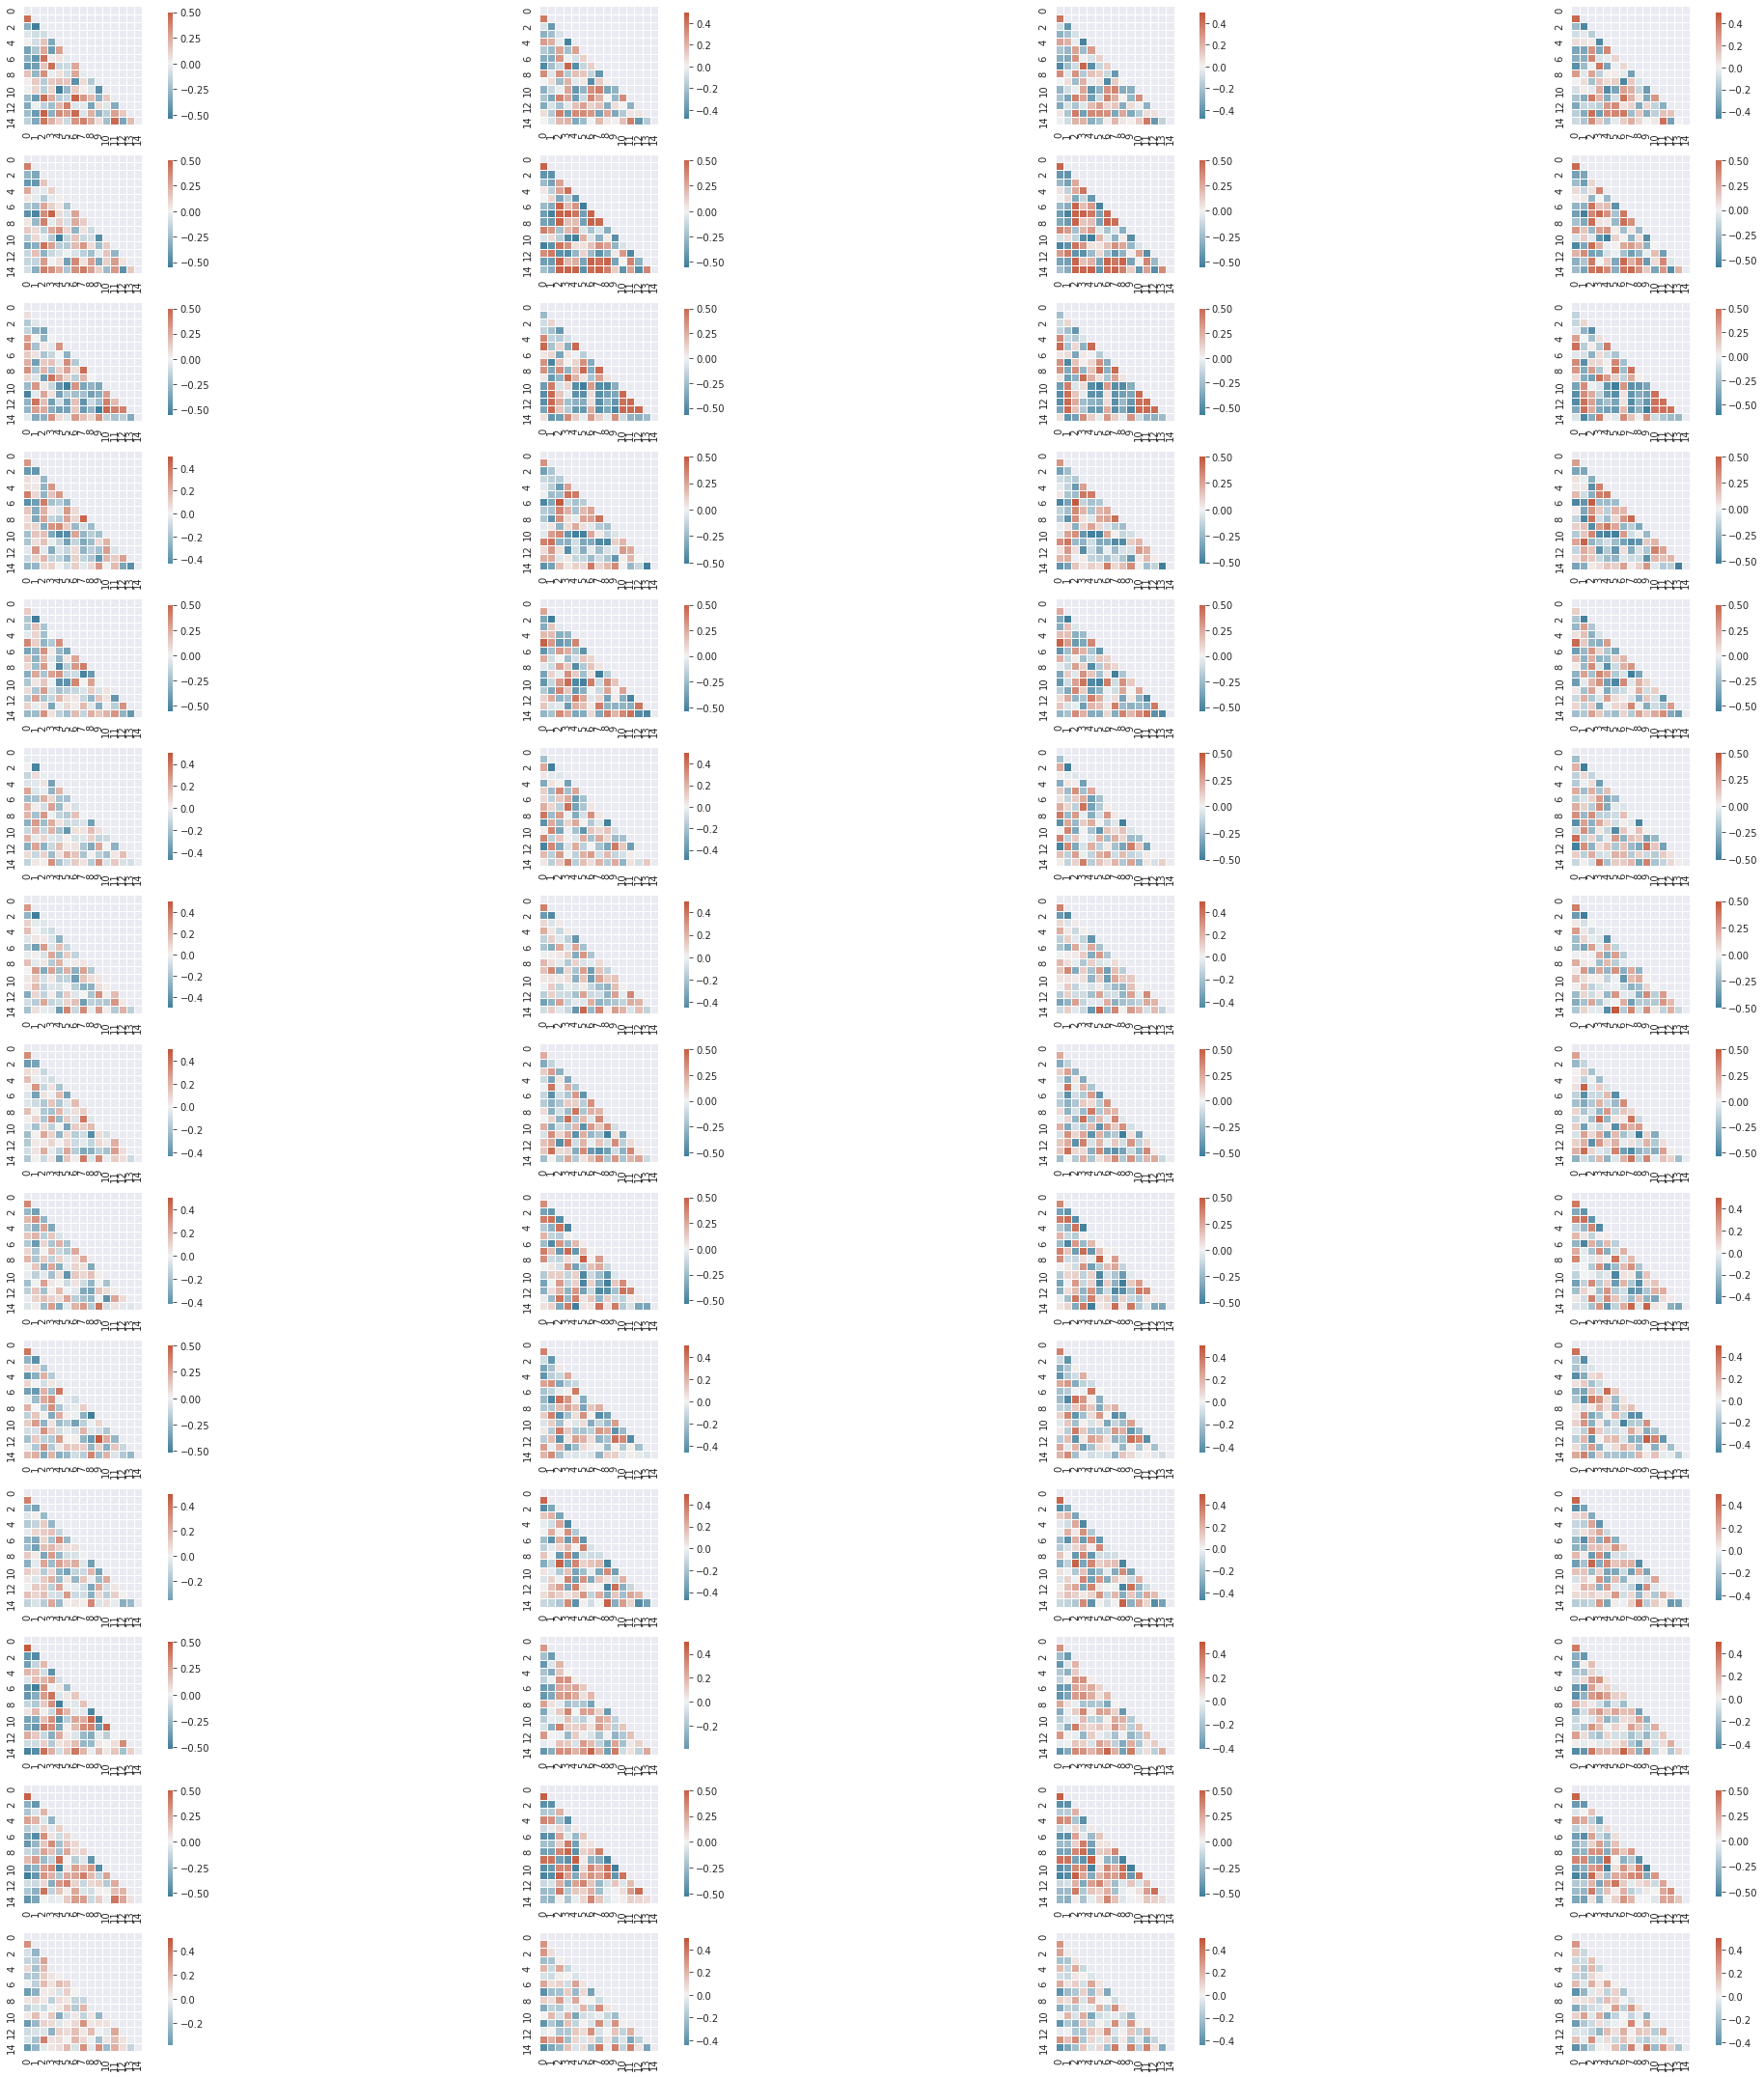

In [64]:
sw_ts = list()
dmn = pd.DataFrame()
fig, axs = plt.subplots(n_slwin, len(wt), figsize=(30, 30), facecolor='white')
for idwt, w_t in enumerate(wt):
    slwin_ts, n_slwin = dynamic_functional_connectivity(np_ts, wl, ss, w_t)  # Windowed BOLD time-series
    for w in range(slwin_ts.shape[1]):
        sw_ts = list()
        for subj in range(slwin_ts.shape[0]):
            sw_ts.append(slwin_ts[subj][w])
        connectome_measure = ConnectivityMeasure(kind='correlation')

        correlation_matrices = connectome_measure.fit_transform(sw_ts)
        mean_correlation_matrix = connectome_measure.mean_

        mask = np.triu(np.ones_like(mean_correlation_matrix, dtype=bool))
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        # Draw the heatmap with the mask and correct aspect ratio
        #dmn[str(w_t)+'w'+str(w)] = mean_correlation_matrix[1]
        sns.heatmap(mean_correlation_matrix, mask=mask, cmap=cmap, vmax=.5, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .9}, annot=False, ax=axs[w, idwt])
fig.tight_layout()
fig.subplots_adjust(wspace=0.001)

In [ ]:
pd.set_option('display.max_rows', 15)
dmn[['rectw12', 'hannw12', 'hammingw12', 'tukeyw12']]